In [1]:
import pandas as pd
import numpy as np
import openpyxl 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path



In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) / 'data' /'processed'
external_dir = Path(TOP) / 'data' /'external'
figures_dir = Path(TOP) / 'reports' /'figures'

In [3]:
import genra_nta

In [4]:
from genra_nta.chm.chem import FingerprintGenerator

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
source = pd.read_csv(external_dir/'toxval_wmetab.csv', index_col = [0])

In [7]:
y = source.set_index('dtxsid')['pPOD']

In [8]:
fp_gen_s = FingerprintGenerator()

In [9]:
fp_gen_s.add_chemicals_from_dataframe(source)
source_FP = fp_gen_s.generate_fingerprints()

[17:05:47] WARNING: not removing hydrogen atom without neighbors
[17:05:47] WARNING: not removing hydrogen atom without neighbors
[17:05:47] WARNING: not removing hydrogen atom without neighbors
[17:05:47] WARNING: not removing hydrogen atom without neighbors
[17:05:47] WARNING: not removing hydrogen atom without neighbors
[17:05:47] WARNING: not removing hydrogen atom without neighbors
[17:05:47] WARNING: not removing hydrogen atom without neighbors


In [10]:
X_train, X_test, y_train, y_test = train_test_split(source_FP, y, test_size=0.20,  random_state=42)

In [17]:
from genra.rax.skl.reg import GenRAPredValue


In [18]:
from sklearn.metrics import make_scorer,explained_variance_score,roc_auc_score,r2_score,f1_score,accuracy_score,precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut


In [19]:
GP1 = GenRAPredValue(algorithm='brute')

params={'n_neighbors': range(1,15),
        'metric':['jaccard','euclidean']
       }


Grid3= GridSearchCV(estimator=GP1,param_grid=params,
                    n_jobs=-1,cv=5,
                    verbose=1,
                    scoring=make_scorer(r2_score))


Best3=Grid3.fit(X_train.values,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/home/grace/miniforge3/envs/py310clone/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/miniforge3/envs/py310clone/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/miniforge3/envs/py310clone/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/miniforge3/envs/py310clone/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/miniforge3/envs/py310clone/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Dat

Best: 0.24824986234262347 {'metric': 'jaccard', 'n_neighbors': 6}


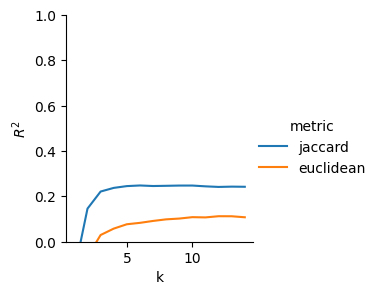

In [20]:
P = pd.DataFrame(Best3.cv_results_['params'])
P.insert(2,'score_mn',Best3.cv_results_['mean_test_score'])
P.insert(3,'score_std',Best3.cv_results_['std_test_score'])

g=sns.FacetGrid(P,hue='metric')
g.map(plt.plot,'n_neighbors','score_mn')
g.set(ylim=(0,1.0),xlabel='k',ylabel='$R^2$')
g.add_legend()
print("Best:", Best3.best_score_,Best3.best_params_)


In [22]:
from genra_nta.nn.nn import NearestNeighborAnalyzer

In [85]:
analyzer = NearestNeighborAnalyzer(n_neighbors=6, metric='jaccard')

In [86]:
analyzer.train_model(source_FP)

In [87]:
mylst = []
for idx in source_FP.index.tolist():
    a = analyzer.find_analogues(target_chemical_id = idx, target_df=source_FP)
    mylst.append(a)

/home/grace/miniforge3/envs/py310clone/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/Documents/python/precision_dir/nts_rax/genra_nta/nn/nn.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: self.fingerprints.index[idx])
/home/grace/miniforge3/envs/py310clone/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/grace/Documents/python/precision_dir/nts_rax/genra_nta/nn/nn.py:54: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: self.fingerprints.index[idx])
/home/grace/miniforge3/envs/py310clone/lib/python3.10/site-p

In [88]:
mylst[0]

,analogue,jaccard,target
0,DTXSID001004378,1.000000,DTXSID001004378
1,DTXSID8065907,0.560976,DTXSID001004378
2,DTXSID5026623,0.325000,DTXSID001004378
3,DTXSID4020583,0.300000,DTXSID001004378
4,DTXSID0027773,0.250000,DTXSID001004378
5,DTXSID10166323,0.239130,DTXSID001004378


In [89]:
y1 = y.reset_index()

In [90]:
from genra_nta.rax.reg.reg import ToxicityPredictor

In [91]:
genra_dict = {}
genra_dict2 = {}
errors = []
for i, df in enumerate(mylst):
    try:
        k = mylst[i]['target'].unique()[0]
        predictor = ToxicityPredictor(analogue_df=df, tox_data=y1, similarity_col='jaccard', activity_col='pPOD')
        a =predictor.join_data()
        weighted_avg = predictor.wtavg()
        
    except Exception as e:
        errors.append([i,e])
    genra_dict[k] = weighted_avg
    genra_dict2[k] = a.jaccard.tolist(), a.pPOD.tolist()

In [30]:
#y_train1

In [94]:
all_toxval = (pd.merge(y1, pd.DataFrame(list(genra_dict.items()), columns = ['target_dtxsid', 'pred_pPOD']), left_on = 'dtxsid', right_on = 'target_dtxsid')
 .drop(['dtxsid'], axis = 1)
 .assign(residual = lambda x: x['pPOD']-x['pred_pPOD'])
)

In [95]:
from sklearn.metrics import r2_score,root_mean_squared_error

In [97]:
r2_score(all_toxval['pPOD'], all_toxval['pred_pPOD'])

0.3156895545136871

In [98]:
root_mean_squared_error(all_toxval['pPOD'], all_toxval['pred_pPOD'])

0.8741607313301095

In [99]:
import seaborn as sns


<Axes: xlabel='pPOD', ylabel='pred_pPOD'>

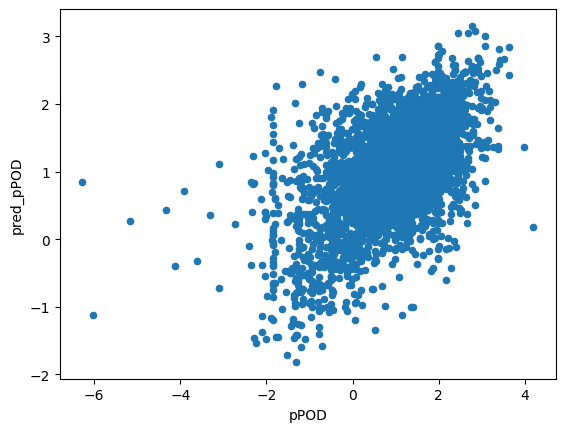

In [100]:
all_toxval.plot(kind = 'scatter', x = 'pPOD', y = 'pred_pPOD')

In [102]:
all_toxval.to_csv(external_dir/'mrgn_toxval_all_predictions.csv')

<Axes: ylabel='Frequency'>

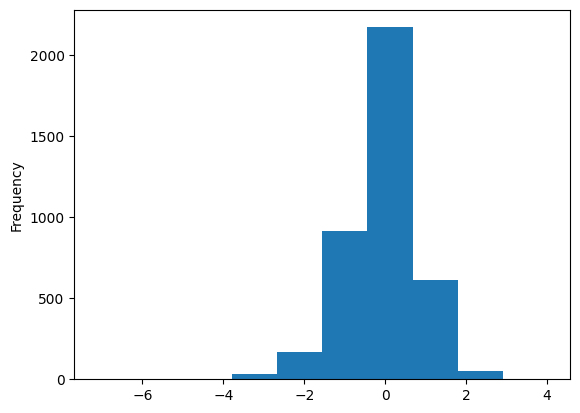

In [103]:
all_toxval['residual'].plot(kind = 'hist')

## Re-try with Embeddings

In [104]:
txval_embeddings_df = pd.read_csv(external_dir/'toxval_rpd_embeddings.csv')

In [105]:
txval_embeddings_df = txval_embeddings_df.set_index('dtxsid')

<Axes: ylabel='dtxsid'>

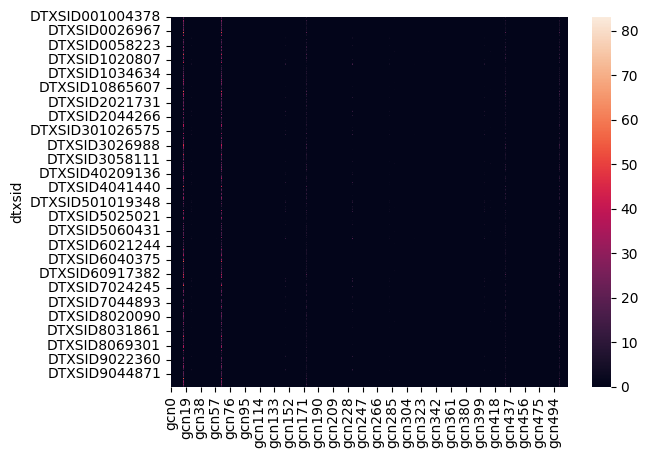

In [106]:
sns.heatmap(txval_embeddings_df)

In [107]:
txval_embeddings_df.to_numpy()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [108]:
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance

In [109]:
from sklearn.metrics.pairwise import euclidean_distances

# Compute Euclidean distance
distance_matrix = euclidean_distances(txval_embeddings_df.to_numpy())

In [110]:
# Min-max normalization
min_dist = np.min(distance_matrix)
max_dist = np.max(distance_matrix)

if max_dist - min_dist > 0:
    D_euc1 = (distance_matrix - min_dist) / (max_dist - min_dist)
else:
    D_euc1 = np.zeros_like(distance_matrix)  # Edge case where all distances are identical


In [111]:
#D_euc1

In [112]:
D_euc = pd.DataFrame(D_euc1, index = txval_embeddings_df.index, columns =txval_embeddings_df.index)

In [113]:
train_ids = X_train.index.tolist()

In [114]:
test_ids = X_test.index.tolist()

In [115]:
len(train_ids)

3166

In [116]:
D_euc1 = D_euc.loc[train_ids, train_ids]

In [117]:
D_euc2 = D_euc.loc[test_ids, test_ids]

<Axes: xlabel='dtxsid', ylabel='dtxsid'>

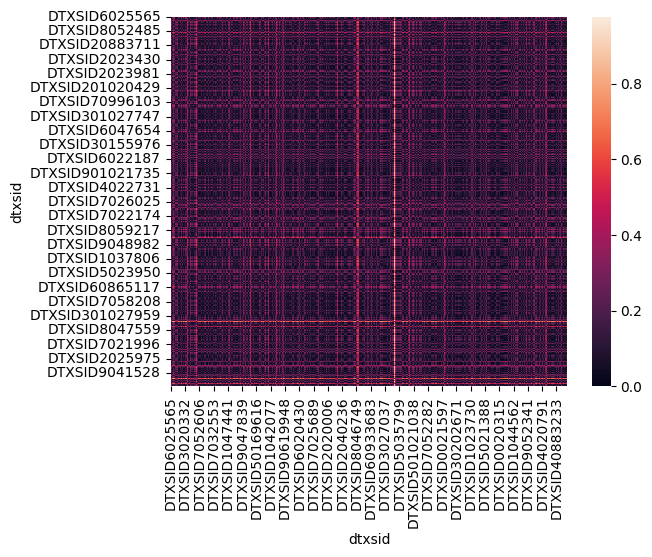

In [118]:
sns.heatmap(D_euc1)

In [42]:
from genra_nta.nn.nn import NearestNeighborAnalyzer

In [119]:
analyzer_emb = NearestNeighborAnalyzer(n_neighbors=6, metric='precomputed')
analyzer_emb.train_model(D_euc)



In [120]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric="precomputed", n_neighbors=6)  # Adjust neighbors as needed
nbrs = nn.fit(D_euc)





In [121]:
def make_analogue(m, FP, target_df, dtx):
    dist, indices = m.kneighbors(target_df.loc[[dtx]])
    neighbour_indices_df = pd.DataFrame(indices)
    sims = 1 - dist
    neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
    analogue_df = pd.concat([neighbour_labels_df.T, pd.DataFrame(sims).T], axis = 1)
    analogue_df['target'] = dtx
    analogue_df.columns = ['analogue', 'jaccard', 'target']
    return analogue_df

In [122]:
mylst_emb = []
for idx in source_FP.index.tolist():
    a = make_analogue(m = nbrs, FP = D_euc, target_df = D_euc, dtx = idx)
    mylst_emb.append(a)

/tmp/ipykernel_296020/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_296020/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_296020/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_296020/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.index[idx])
/tmp/ipykernel_296020/2117032366.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  neighbour_labels_df = neighbour_indices_df.applymap(lambda idx: FP.in

In [123]:
pd.concat(mylst).to_csv(external_dir/'mrgn_analogues_txval.csv')

In [124]:
pd.concat(mylst_emb).to_csv(external_dir/'embed_analogues_txval.csv')

In [125]:
genra_dict2 = {}

errors = []
for i, df in enumerate(mylst_emb):
    try:
        k = mylst_emb[i]['target'].unique()[0]
        predictor = ToxicityPredictor(analogue_df=df, tox_data=y1, similarity_col='jaccard', activity_col='pPOD')
        a =predictor.join_data()
        weighted_avg = predictor.wtavg()
        
    except Exception as e:
        errors.append([i,e])
    genra_dict2[k] = weighted_avg
    

In [126]:
embed_toxval = (pd.merge(y1, pd.DataFrame(list(genra_dict2.items()), columns = ['target_dtxsid', 'pred_pPOD']), left_on = 'dtxsid', right_on = 'target_dtxsid')
 .drop(['dtxsid'], axis = 1)
 .assign(residual = lambda x: x['pPOD']-x['pred_pPOD'])
)

In [127]:
embed_toxval
r2_score(embed_toxval['pPOD'], embed_toxval['pred_pPOD'])

0.3807010036455043

In [128]:
root_mean_squared_error(embed_toxval['pPOD'], embed_toxval['pred_pPOD'])

0.8316007969969309

<Axes: xlabel='pPOD', ylabel='pred_pPOD'>

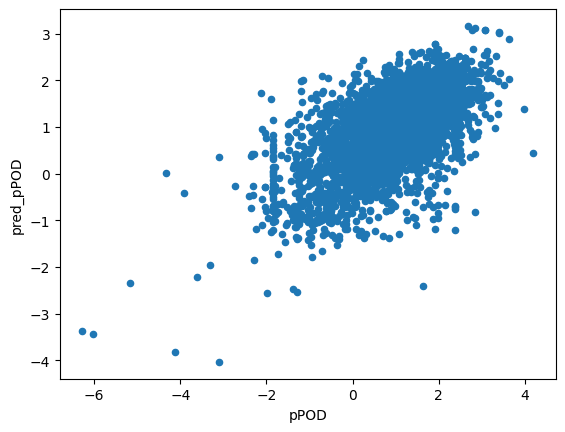

In [129]:
embed_toxval.plot(kind = 'scatter', x = 'pPOD', y = 'pred_pPOD')


<Axes: ylabel='Frequency'>

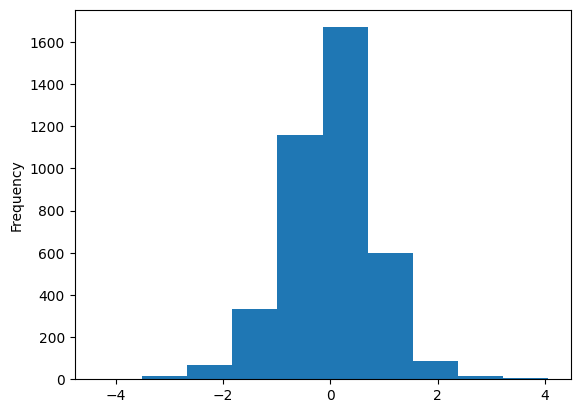

In [130]:
embed_toxval['residual'].plot(kind = 'hist')

In [152]:
embed_toxval.to_csv(external_dir/'embed_genra_txval.csv')

In [134]:
embed_toxval.head()

,pPOD,target_dtxsid,pred_pPOD,residual
0,1.279506,DTXSID001004378,1.186551,0.092955
1,2.180879,DTXSID001005033,2.048987,0.131892
2,0.348332,DTXSID001009930,-0.190743,0.539075
3,0.667420,DTXSID001016113,0.979125,-0.311705
4,1.555941,DTXSID001019355,0.689474,0.866466


In [135]:
all_toxval.head()

,pPOD,target_dtxsid,pred_pPOD,residual
0,1.279506,DTXSID001004378,1.330516,-0.051010
1,2.180879,DTXSID001005033,1.416458,0.764421
2,0.348332,DTXSID001009930,-0.093529,0.441861
3,0.667420,DTXSID001016113,0.859924,-0.192503
4,1.555941,DTXSID001019355,0.924381,0.631560


In [147]:
from sklearn.metrics import r2_score

In [148]:
def bootstrap_r2_diff(y_true, y_pred1, y_pred2, n_bootstrap=1000):
    np.random.seed(42)
    diffs = []
    n = len(y_true)
    
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, n, replace=True)
        r2_1 = r2_score(y_true[idx], y_pred1[idx])
        r2_2 = r2_score(y_true[idx], y_pred2[idx])
        diffs.append(r2_1 - r2_2)
    
    ci_lower, ci_upper = np.percentile(diffs, [2.5, 97.5])
    p_value = (np.sum(np.array(diffs) <= 0) / n_bootstrap)  # One-sided test
    
    return ci_lower, ci_upper, p_value, diffs

In [149]:
ci_lower, ci_upper, p_value, diffs = bootstrap_r2_diff(all_toxval.pPOD,  embed_toxval.pred_pPOD,all_toxval.pred_pPOD)
print(f"95% CI: ({ci_lower:.3f}, {ci_upper:.3f}), p-value: {p_value:.3f}")

95% CI: (0.021, 0.107), p-value: 0.002


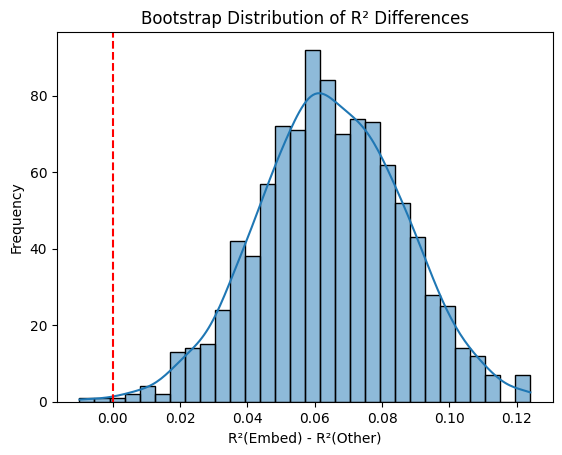

In [150]:
_ ,_ ,_, diffs = bootstrap_r2_diff(all_toxval.pPOD, embed_toxval.pred_pPOD, all_toxval.pred_pPOD,)

sns.histplot(diffs, bins=30, kde=True)
plt.axvline(0, color='red', linestyle='dashed')
plt.xlabel("R²(Embed) - R²(Other)")
plt.ylabel("Frequency")
plt.title("Bootstrap Distribution of R² Differences")
plt.show()


In [151]:
np.mean(np.array(diffs) > 0)

0.998